# 异常点检测模型实验
> 一个小测试。

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]

In [403]:
import sys
import time
# import logging
import datetime
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.tseries.offsets import *

# import plotly_express as px
# import cufflinks as cf

from sklearn import preprocessing

from tqdm import tqdm_notebook as tqdm

# 数据加载

In [412]:
#collapse-show
df = pd.read_csv('./sample_21.txt')
df

,交易时间,交易金额,转账附言,渠道,发起方id,发起方年龄,发起方所处地区,接收方ID
0,2017-12-23 00:07:36,1989200,转账,普通转账,3655,22,广东,44
1,2017-12-23 00:08:25,4802500,-,线下付款,2703,50,新疆,47
2,2017-12-23 00:12:37,3254000,-,线上付款,3476,36,安徽,92
3,2017-12-23 00:12:50,3458600,-,线下付款,6017,31,贵州,43
4,2017-12-23 00:13:21,2085400,奖金,普通转账,1904,37,云南,18
...,...,...,...,...,...,...,...,...
20016,2018-02-28 14:07:39,2515300,上次买的xx,跨境转账,304,23,美国,71
20017,2018-02-28 14:35:16,4910500,李xx给张xx的钱,普通转账,3689,32,黑龙江,55
20018,2018-02-28 14:40:07,3096400,李xx给张xx的钱,普通转账,320,35,上海,24
20019,2018-02-28 14:41:10,3661000,还给你,普通转账,3909,42,上海,90


In [411]:
df.columns = ['time', 'cash_amount', 'comment', 'channel', 'starter_id', 'starter_age', 'starter_area', 'receiver_id']

df.describe()

,cash_amount,starter_id,starter_age,receiver_id
count,2.002100e+04,20021.000000,20021.000000,20021.000000
mean,2.509762e+06,3498.215674,33.934369,51.956895
std,1.446299e+06,2013.401076,9.564053,80.228028
min,1.010000e+04,1.000000,18.000000,1.000000
25%,1.264900e+06,1754.000000,26.000000,26.000000
50%,2.492100e+06,3500.000000,34.000000,51.000000
75%,3.751800e+06,5238.000000,42.000000,76.000000
max,8.888800e+06,7000.000000,88.000000,6258.000000


# 数据探索

详见 [《AliAntTest_数据探索及模型选择.pdf》]({{site.baseurl}}/images/AliAntTest_数据探索及模型选择.pdf)。

# 特征提取

尝试从下面三个维度提取特征，并比较提取特征的优劣：

1. 基于事实表的特征提取
2. 基于ID之间交易的特征提取
3. 基于ID的特征提取

> Notes: 其实从数据探索过程中可以发现第3种最好，但实际场景下特征维度会非常多，所以特征提取前期应该尽可能多的探索一下。

> Notes: 特征提取方法：连续值用z-score归一化处理，离散值用one-hot方法做稀疏处理。

## 基于事实表的特征提取

可用于构造特征的维度有：

- 交易金额；
- 交易数量；
- 发起地区；
- 年龄；
- 渠道；

### z-score标准化: 交易金额、年龄

In [6]:
z_score_scaler = preprocessing.StandardScaler()
z_score_feature = z_score_scaler.fit_transform(df[['cash_amount', 'starter_age']])

In [7]:
features = pd.DataFrame(z_score_feature, columns=['cash_amount', 'starter_age'])

In [8]:
features

,cash_amount,starter_age
0,-0.359936,-1.247867
1,1.585284,1.679835
2,0.514594,0.215984
3,0.656062,-0.306820
4,-0.293420,0.320545
...,...,...
20016,0.003829,-1.143306
20017,1.659959,-0.202259
20018,0.405623,0.111423
20019,0.796009,0.843349


### OneHot——渠道

In [9]:
ch_one_hot_enc = preprocessing.OneHotEncoder()
ch_one_hot_enc.fit(df[['channel']])
# enc.n_values_

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [10]:
ch_one_hot_enc

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [11]:
res = ch_one_hot_enc.transform(df[['channel']]).toarray()

In [12]:
for i in range(res.shape[1]):
    features[f'ch_{i}'] = res.T[0]

In [13]:
features

,cash_amount,starter_age,ch_0,ch_1,ch_2,ch_3
0,-0.359936,-1.247867,1.0,1.0,1.0,1.0
1,1.585284,1.679835,0.0,0.0,0.0,0.0
2,0.514594,0.215984,0.0,0.0,0.0,0.0
3,0.656062,-0.306820,0.0,0.0,0.0,0.0
4,-0.293420,0.320545,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...
20016,0.003829,-1.143306,0.0,0.0,0.0,0.0
20017,1.659959,-0.202259,1.0,1.0,1.0,1.0
20018,0.405623,0.111423,1.0,1.0,1.0,1.0
20019,0.796009,0.843349,1.0,1.0,1.0,1.0


### OneHot：starter_area

In [183]:
area_one_hot_enc = preprocessing.OneHotEncoder()
area_one_hot_enc.fit(df[['starter_area']])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [184]:
area_one_hot_enc

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [185]:
res = area_one_hot_enc.transform(df[['starter_area']]).toarray()

In [186]:
for i in range(res.shape[1]):
    features[f'area_{i}'] = res.T[0]

In [187]:
features

,cash_amount,starter_age,ch_0,ch_1,ch_2,ch_3,area_0,area_1,area_2,area_3,...,area_11,area_12,area_13,area_14,area_15,area_16,area_17,area_18,area_19,area_20
0,-0.359936,-1.247867,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.585284,1.679835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.514594,0.215984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.656062,-0.306820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.293420,0.320545,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20016,0.003829,-1.143306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20017,1.659959,-0.202259,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20018,0.405623,0.111423,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
20019,0.796009,0.843349,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### 降维观察特征的有效性

In [14]:
import ipyvolume as ipv

In [15]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
res = tsne.fit_transform(features)

CPU times: user 12min 31s, sys: 222 ms, total: 12min 31s
Wall time: 1min 29s


In [31]:
df_res = pd.DataFrame(index=features.index)

for i in range(3):
    df_res[i] = _res[:, i]

In [32]:
df_res

,0,1,2
0,18.165588,-19.010647,1.458440
1,4.450019,-1.731154,-32.102139
2,-14.175321,3.815895,-3.988426
3,-5.928217,-7.826748,-10.185696
4,13.656402,5.804957,-2.203535
...,...,...,...
20016,-4.421280,-13.237238,13.659069
20017,-0.839358,-8.010888,-3.395279
20018,12.696962,1.771047,9.034929
20019,4.095841,16.873896,3.948498


In [33]:
df_res.describe()

,0,1,2
count,20021.000000,20021.000000,20021.000000
mean,0.329172,-0.163093,0.102560
std,13.911817,15.107344,12.062253
min,-28.235468,-34.582352,-32.145741
25%,-10.466891,-11.949810,-8.984593
50%,0.032380,-0.298013,1.127379
75%,11.903912,10.771826,8.706995
max,29.233423,29.592445,28.516783


In [19]:
from matplotlib import cm
import ipyvolume as ipv

colormap = cm.Spectral
# _c = [i*3 for i in pd.Categorical(df_res['id']).codes]
# color = colormap(_c)
ipv.quickscatter(df_res[0], df_res[1], df_res[2], size=1)    # , marker="sphere", color=color[:,:3]

![](ali_ant/TSNE_1.png)

> Note: 从降维后的结果可以看到：这种方法提取的特征无法区分数据。

## 基于ID之间交易的特征提取

在数据从交易信息来看，没有明显的分布差别，所以在这里不予考虑。

## 基于ID的特征提取 

从四个维度来提取：

- 发起交易的金额总量和交易数；
- 接收交易的金额总量和交易数；

#### 发起交易的金额总量和交易数

In [350]:
f = {'cash_amount': ['count', 'sum']}
starter_df = df.groupby('starter_id').aggregate(f)
starter_df.columns = ['_'.join(col).strip() for col in starter_df.columns.values]

In [351]:
starter_df.columns = ['s_cash_amount_count', 's_cash_amount_sum']

In [352]:
starter_df

,s_cash_amount_count,s_cash_amount_sum
starter_id,,
1,1,2764000
2,5,18098000
3,3,8589800
4,6,16682400
5,2,5435500
...,...,...
6996,5,9014400
6997,3,3548100
6998,1,2878000


#### 接收交易的金额总量和交易数

In [353]:
f = {'cash_amount': ['count', 'sum']}
receiver_df = df.groupby('receiver_id').aggregate(f)
receiver_df.columns = ['_'.join(col).strip() for col in receiver_df.columns.values]

In [354]:
receiver_df.columns = ['e_cash_amount_count', 'e_cash_amount_sum']
receiver_df

,e_cash_amount_count,e_cash_amount_sum
receiver_id,,
1,202,497892400
2,179,457216300
3,201,505419500
4,214,539274100
5,222,562892800
...,...,...
1434,1,8888800
3012,1,405300
4962,1,3279200


In [355]:
features = receiver_df.join(starter_df, how='outer')

In [356]:
# 填充NaN
features = features.fillna(0)
features

,e_cash_amount_count,e_cash_amount_sum,s_cash_amount_count,s_cash_amount_sum
1,202.0,497892400.0,1.0,2764000.0
2,179.0,457216300.0,5.0,18098000.0
3,201.0,505419500.0,3.0,8589800.0
4,214.0,539274100.0,6.0,16682400.0
5,222.0,562892800.0,2.0,5435500.0
...,...,...,...,...
6996,0.0,0.0,5.0,9014400.0
6997,0.0,0.0,3.0,3548100.0
6998,0.0,0.0,1.0,2878000.0
6999,0.0,0.0,5.0,15088000.0


#### 归一化

In [357]:
z_score_scaler = preprocessing.StandardScaler()
z_score_feature = z_score_scaler.fit_transform(features)

In [358]:
_features = pd.DataFrame(z_score_feature, index=features.index)

In [359]:
_features

,0,1,2,3
1,8.122062,7.981598,-1.276431,-0.988593
2,7.183164,7.319397,1.232125,2.134452
3,8.081240,8.104138,-0.022153,0.197936
4,8.611921,8.655286,1.859264,1.846140
5,8.938494,9.039796,-0.649292,-0.444493
...,...,...,...,...
6996,-0.123907,-0.124019,1.232125,0.284414
6997,-0.123907,-0.124019,-0.022153,-0.828896
6998,-0.123907,-0.124019,-1.276431,-0.965374
6999,-0.123907,-0.124019,1.232125,1.521412


### 降维观察特征有效性

In [101]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
_res = tsne.fit_transform(_features)

CPU times: user 3min 30s, sys: 128 ms, total: 3min 30s
Wall time: 25.5 s


In [111]:
df_res = pd.DataFrame(index=_features.index)

for i in range(3):
    df_res[i] = _res[:, i]

In [112]:
df_res.reset_index(inplace=True)

In [113]:
df_res

,index,0,1,2
0,0,-2.616519,10.399817,16.650976
1,1,0.269044,8.815780,21.424440
2,2,-1.138858,9.294405,19.571409
3,3,-0.300031,9.371153,21.505943
4,4,-3.027676,11.100630,18.954000
...,...,...,...,...
6591,6591,9.084714,10.959700,-5.038331
6592,6592,-4.531178,27.202545,-1.383322
6593,6593,-14.335349,-15.130382,-5.814716
6594,6594,1.527327,-24.622822,-3.664261


In [114]:
from matplotlib import cm
import ipyvolume as ipv

colormap = cm.Spectral
# _c = [i*3 for i in pd.Categorical(df_res['id']).codes]
# color = colormap(_c)
ipv.quickscatter(df_res[0], df_res[1], df_res[2], size=1)    # , marker="sphere", color=color[:,:3]

![](ali_ant/TSNE_2.png)

> Note: 从降维后的结果可以看到：这种方法提取的特征很容易异常数据。

# 构建模型

使用下面3种方式构建模型：

- K-means；
- 谱聚类模型；
- 孤立森林Isolation Forest。

## K-means聚类模型

In [425]:
%%time
from sklearn.cluster import KMeans

y_pred = KMeans(n_clusters=2, random_state=10).fit_predict(_features)

CPU times: user 143 ms, sys: 299 ms, total: 442 ms
Wall time: 39.2 ms


In [324]:
from matplotlib import cm
import ipyvolume as ipv

df_res = _features.reset_index()
# pd.Categorical(y_pred).codes
colormap = cm.Spectral
_c = [i*100 for i in pd.Categorical(y_pred).codes]
color = colormap(_c)
ipv.quickscatter(df_res[0], df_res[1], df_res[3], size=2, marker="sphere", color=color[:,:3]) 

![](ali_ant/Kmeans_res.png)

In [426]:
_df = pd.DataFrame(y_pred, index=_features.index)

In [428]:
features.loc[_df[_df[0]==1].index]

,e_cash_amount_count,e_cash_amount_sum,s_cash_amount_count,s_cash_amount_sum
1,202.0,497892400.0,1.0,2764000.0
2,179.0,457216300.0,5.0,18098000.0
3,201.0,505419500.0,3.0,8589800.0
4,214.0,539274100.0,6.0,16682400.0
5,222.0,562892800.0,2.0,5435500.0
...,...,...,...,...
96,208.0,508578500.0,0.0,0.0
97,191.0,443328700.0,1.0,4635800.0
98,187.0,468610000.0,2.0,5157900.0
99,182.0,431347100.0,3.0,10525300.0


> Note: 耗时39ms，但效果很差。

## 谱聚类模型

In [420]:
%%time
from sklearn.cluster import SpectralClustering

y_pred = SpectralClustering(n_clusters=2).fit_predict(_features)

CPU times: user 19.1 s, sys: 18 s, total: 37.1 s
Wall time: 6.64 s


In [329]:
from matplotlib import cm
import ipyvolume as ipv

df_res = _features.reset_index()
# pd.Categorical(y_pred).codes
colormap = cm.Spectral
_c = [i*100 for i in pd.Categorical(y_pred).codes]
color = colormap(_c)
ipv.quickscatter(df_res[0], df_res[1], df_res[3], size=2, marker="sphere", color=color[:,:3]) 

In [421]:
_df = pd.DataFrame(y_pred, index=_features.index)

In [424]:
_df[_df[0]==1]

,0
1137,1


In [423]:
features.loc[_df[_df[0]==1].index]

,e_cash_amount_count,e_cash_amount_sum,s_cash_amount_count,s_cash_amount_sum
1137,0.0,0.0,12.0,106665600.0


![](ali_ant/spectral_res.png)

> Note: 耗时6.46s，效果很好。

> Note: 异常数据为：

![](ali_ant/异常数据.png)

## IsolationForest方法

In [331]:
features = _features

In [404]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from scipy import stats

rng = np.random.RandomState(42)
 
# 构造训练样本
n_samples = features.shape[0]  #样本总数
outliers_fraction = 1/n_samples  #异常样本比例

clf = IsolationForest(max_samples=n_samples , random_state=rng, contamination=outliers_fraction)   # , random_state=rng, contamination=outliers_fraction
clf.fit(features)
# y_pred_train = clf.predict(X_train)
scores_pred = clf.decision_function(features)
threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)  #根据训练样本中异常样本比例，得到阈值，用于绘图

CPU times: user 616 ms, sys: 995 µs, total: 617 ms
Wall time: 616 ms


In [396]:
scores_pred

array([0.19802162, 0.08466044, 0.21168621, ..., 0.38757413, 0.38741914,
       0.42611375])

In [397]:
threshold

5.525365321529252e-17

In [398]:
_df = pd.DataFrame(scores_pred)

In [405]:
res = _df[_df[0] < threshold]

In [400]:
features.iloc[res.index]

,e_cash_amount_count,e_cash_amount_sum,s_cash_amount_count,s_cash_amount_sum
1137,0.0,0.0,12.0,106665600.0


> Note: 效果：耗时616ms，结果准确。

## 模型比较

从运行结果来看，三种模型里：

- K-Means效果最差，其余两种效果很好；
- 谱聚类模型性能比较差，运行时间是Isolation Forest模型的6倍。

# TODO

- 降到二维/三维可视化展示聚类效果。

In [401]:
#hide
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from scipy import stats
 
rng = np.random.RandomState(42)
 
# 构造训练样本
n_samples = 200  #样本总数
outliers_fraction = 0.25  #异常样本比例
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
 
X = 0.3 * rng.randn(n_inliers // 2, 2)
X_train = np.r_[X + 2, X - 2]   #正常样本
X_train = np.r_[X_train, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]  #正常样本加上异常样本
 
# fit the model
clf = IsolationForest(max_samples=n_samples)     # , random_state=rng, contamination=outliers_fraction
clf.fit(X_train)
# y_pred_train = clf.predict(X_train)
scores_pred = clf.decision_function(X_train)
threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)  #根据训练样本中异常样本比例，得到阈值，用于绘图
 
# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-7, 7, 50), np.linspace(-7, 7, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


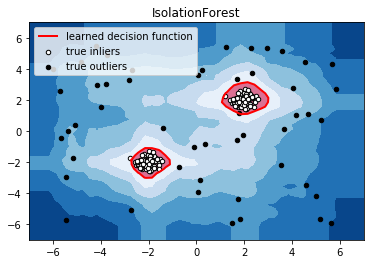

In [402]:
#hide
plt.title("IsolationForest")
# plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)  #绘制异常点区域，值从最小的到阈值的那部分
a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')  #绘制异常点区域和正常点区域的边界
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='palevioletred')  #绘制正常点区域，值从阈值到最大的那部分
 
b = plt.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',
                    s=20, edgecolor='k')
c = plt.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black',
                    s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-7, 7))
plt.ylim((-7, 7))
plt.legend([a.collections[0], b, c],
           ['learned decision function', 'true inliers', 'true outliers'],
           loc="upper left")
plt.show()